In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image_path = '/content/Bscan_1957_pos_12.png'
image = cv2.imread(image_path)

(<matplotlib.image.AxesImage at 0x78f044711e70>,
 Text(0.5, 1.0, 'Original Image'))

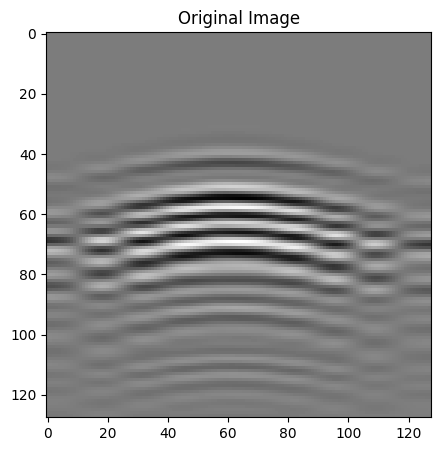

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')

In [ ]:
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
gray_image = to_grayscale(image)

(<matplotlib.image.AxesImage at 0x78f044788a00>,
 Text(0.5, 1.0, 'Grayscale Image'))

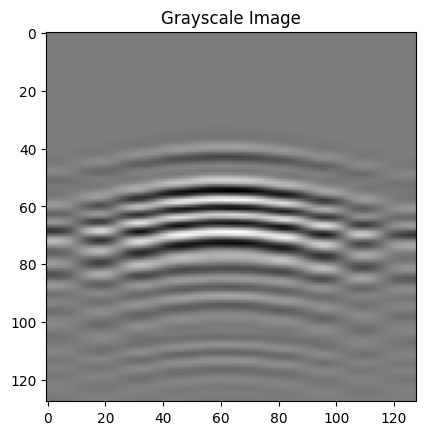

In [ ]:
plt.imshow(gray_image, cmap='gray'), plt.title('Grayscale Image')

(<matplotlib.image.AxesImage at 0x78f0445feb30>,
 Text(0.5, 1.0, 'Blurred Image'))

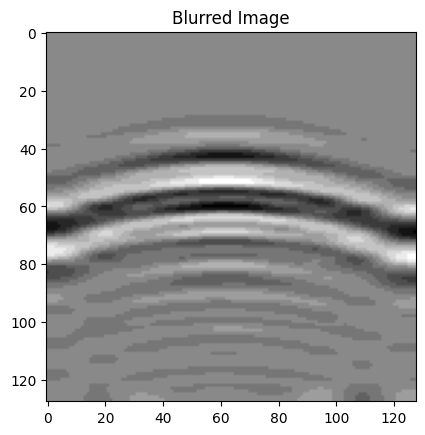

In [ ]:
def apply_gaussian_blur(image, kernel_size=15, sigma=4):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

blurred_image = apply_gaussian_blur(gray_image)

plt.imshow(blurred_image, cmap='gray'), plt.title('Blurred Image')

(<matplotlib.image.AxesImage at 0x78f04468dcc0>,
 Text(0.5, 1.0, 'Gradient Magnitude'))

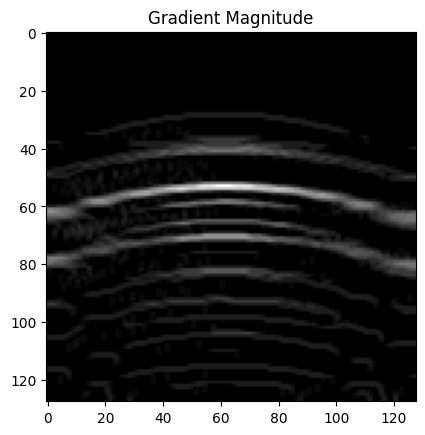

In [ ]:
def compute_gradients(image):
    Kx = np.array([[-2, -1, 0, 1, 2],
                   [-2, -1, 0, 1, 2],
                   [-4, -2, 0, 2, 4],
                   [-2, -1, 0, 1, 2],
                   [-2, -1, 0, 1, 2]])

    Ky = np.array([[2, 2, 4, 2, 2],
                   [1, 1, 2, 1, 1],
                   [0, 0, 0, 0, 0],
                   [-1, -1, -2, -1, -1],
                   [-2, -2, -4, -2, -2]])
    Ix = cv2.filter2D(image, -1, Kx)
    Iy = cv2.filter2D(image, -1, Ky)
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return G, theta

gradient_magnitude, gradient_direction = compute_gradients(blurred_image)

plt.imshow(gradient_magnitude, cmap='gray'), plt.title('Gradient Magnitude')

(<matplotlib.image.AxesImage at 0x78f044517610>,
 Text(0.5, 1.0, 'Non-Maximum Suppression'))

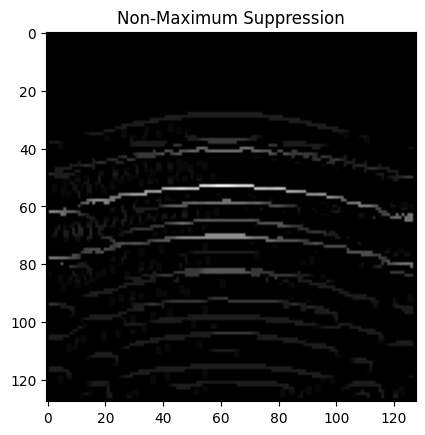

In [ ]:
def non_maximum_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                # angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                # angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                # angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                # angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                if (G[i,j] >= q) and (G[i,j] >= r):
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    return Z

non_max_suppressed_image = non_maximum_suppression(gradient_magnitude, gradient_direction)

plt.imshow(non_max_suppressed_image, cmap='gray'), plt.title('Non-Maximum Suppression')

(<matplotlib.image.AxesImage at 0x78f044598340>,
 Text(0.5, 1.0, 'Double Threshold'))

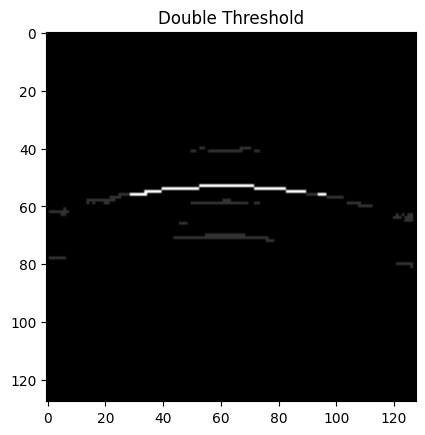

In [ ]:
def double_threshold(img, lowThreshold, highThreshold):
    weak = 50
    strong = 255

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    img[strong_i, strong_j] = strong
    img[zeros_i, zeros_j] = 0
    img[weak_i, weak_j] = weak

    return img, weak, strong

thresholded_image, weak, strong = double_threshold(non_max_suppressed_image, 100, 150)

plt.imshow(thresholded_image, cmap='gray'), plt.title('Double Threshold')

(<matplotlib.image.AxesImage at 0x78f0444171f0>,
 Text(0.5, 1.0, 'Canny Edge Detection'))

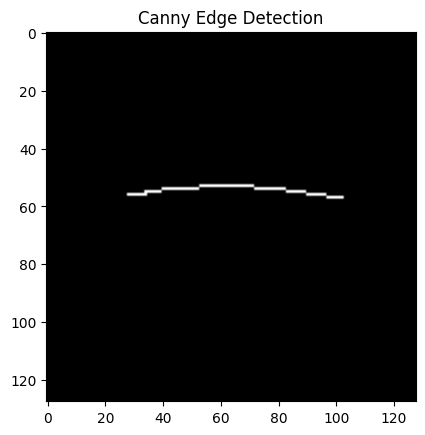

In [ ]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

canny_edge_image = hysteresis(thresholded_image, weak, strong)

plt.imshow(canny_edge_image, cmap='gray'), plt.title('Canny Edge Detection')